## Exercise 5: ERP Detection
**Objective:** Identify event-related potentials (ERPs) from simulated EEG data.
- **Libraries:** `numpy`, `matplotlib`
- **Tasks:**
  - Simulate an EEG signal with added ERP components.
  - Detect and visualize ERPs using signal averaging.
- **Expected Output:** Plot highlighting detected ERP components.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import mne

### Load data

In [11]:
root = mne.datasets.sample.data_path() / "MEG" / "sample"
raw_file = root / "sample_audvis_filt-0-40_raw.fif"
raw = mne.io.read_raw_fif(raw_file, preload=False)

events_file = root / "sample_audvis_filt-0-40_raw-eve.fif"
events = mne.read_events(events_file)

raw.crop(tmax=90)  # in seconds (happens in-place)
# discard events >90 seconds (not strictly necessary, but avoids some warnings)
events = events[events[:, 0] <= raw.last_samp]

Opening raw data file C:\Users\USER\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


In [12]:
raw.pick(["eeg", "eog"]).load_data()
raw.info

Reading 0 ... 13514  =      0.000 ...    90.001 secs...


<Info | 14 non-empty values
 bads: 1 items (EEG 053)
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 61
 projs: Average EEG reference: off
 sfreq: 150.2 Hz
>

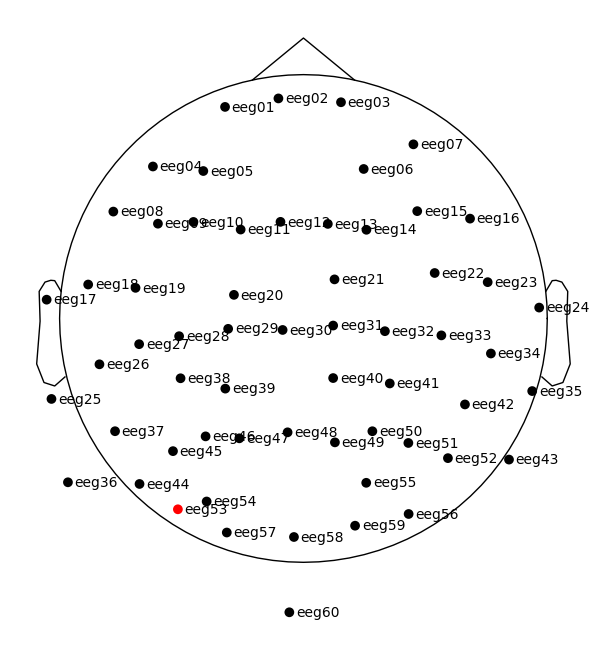

In [20]:
channel_renaming_dict = {name: name.replace(" 0", "").lower() for name in raw.ch_names}
raw.rename_channels(channel_renaming_dict) 
raw.plot_sensors(show_names=True);

In [22]:
raw.filter(l_freq=0.1, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 4957 samples (33.013 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<Raw | sample_audvis_filt-0-40_raw.fif, 61 x 13515 (90.0 s), ~9.2 MB, data loaded>

### Epoching and averaging

In [24]:
np.unique(events[:, -1])

event_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "face": 5,
    "buttonpress": 32,
}

Not setting metadata
132 matching events found
Setting baseline interval to [-0.2996928197375818, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 132 events and 151 original time points ...
1 bad epochs dropped
You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


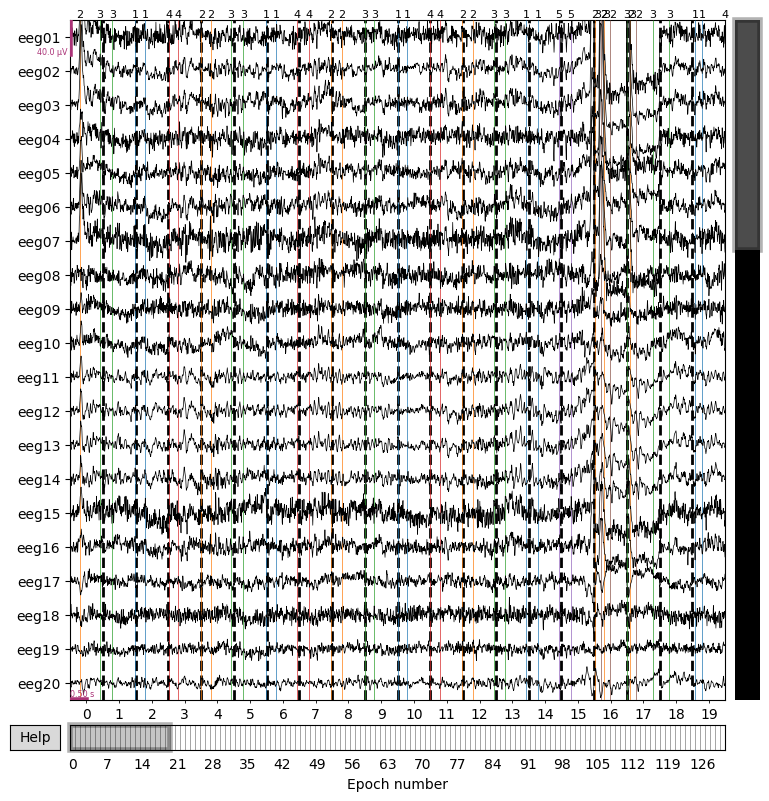

In [25]:
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.3, tmax=0.7, preload=True)
fig = epochs.plot(events=events)

0 bad epochs dropped


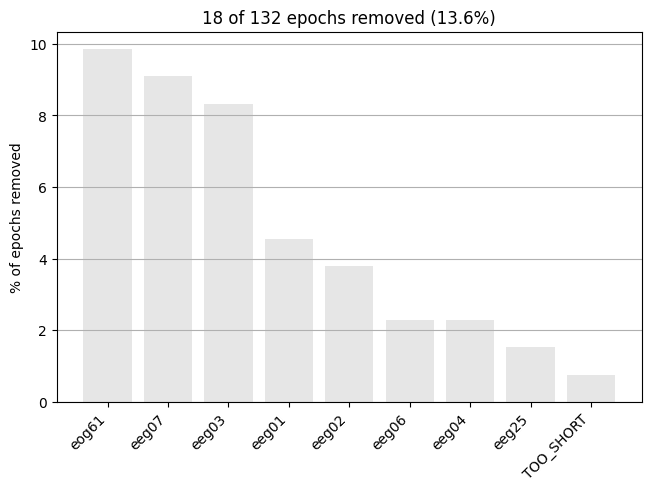

In [29]:
# rejection based on peak-to-peak amplitudes 

reject_criteria = dict(eeg=100e-6, eog=200e-6)  # 100 µV, 200 µV
epochs.drop_bad(reject=reject_criteria)
epochs.plot_drop_log();

### Compare auditory and visual conditions

In [30]:
l_aud = epochs["auditory/left"].average()
l_vis = epochs["visual/left"].average()

Projections have already been applied. Setting proj attribute to True.


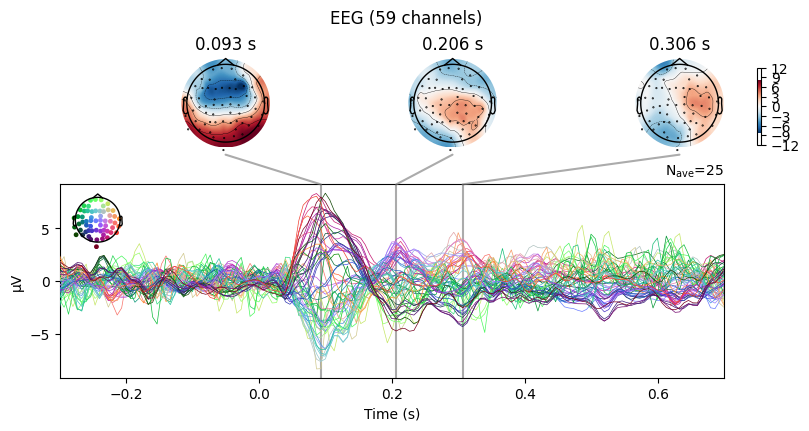

In [33]:
l_aud.plot_joint();

Projections have already been applied. Setting proj attribute to True.


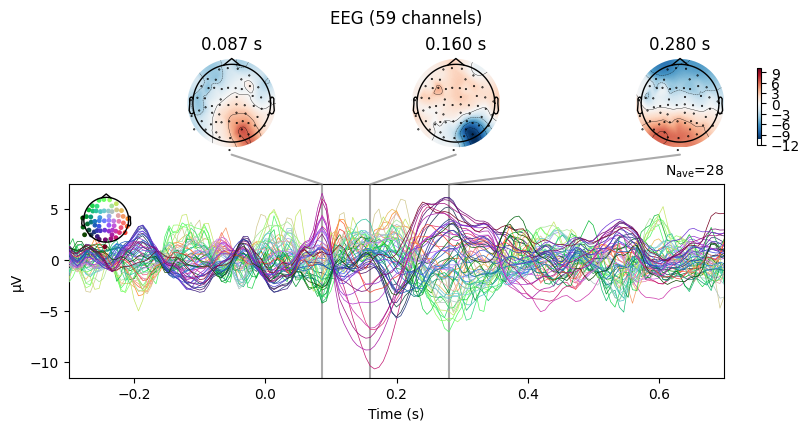

In [34]:
l_vis.plot_joint();

combining channels using "mean"
combining channels using "mean"


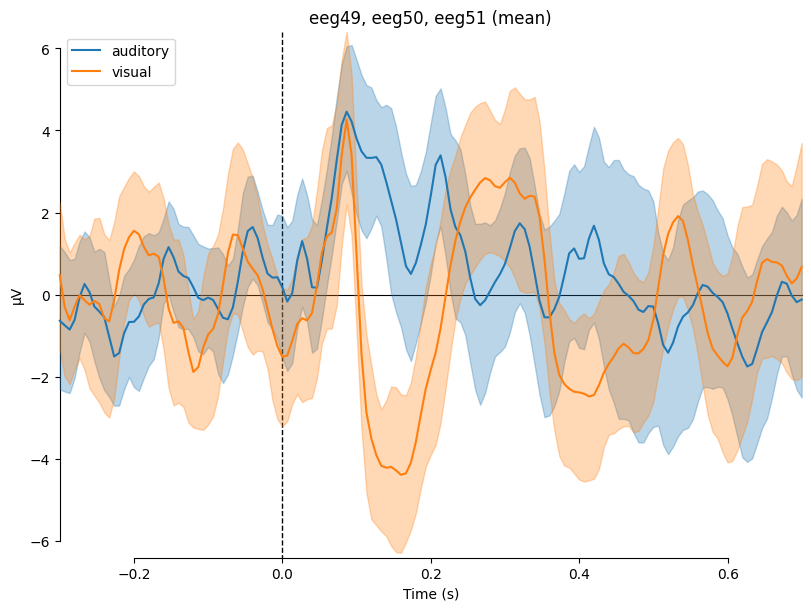

[<Figure size 800x600 with 1 Axes>]

In [38]:
picks = [f"eeg{n}" for n in range(49, 52)]


evokeds = dict(
    auditory=list(epochs["auditory/left"].iter_evoked()),
    visual=list(epochs["visual/left"].iter_evoked()),
)
mne.viz.plot_compare_evokeds(evokeds, combine="mean", picks=picks)

Projections have already been applied. Setting proj attribute to True.


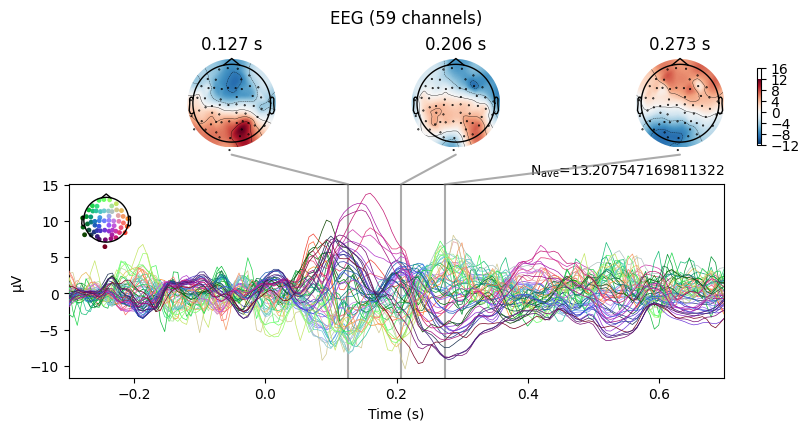

In [40]:
aud_minus_vis = mne.combine_evoked([l_aud, l_vis], weights=[1, -1])
aud_minus_vis.plot_joint(); 

In [41]:
grand_average = mne.grand_average([l_aud, l_vis])
print(grand_average)

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors
Identifying common channels ...
<Evoked | 'Grand average (n = 2)' (average, N=2), -0.29969 – 0.69928 s, baseline -0.299693 – 0 s, 60 ch, ~3.0 MB>


### References 

* [MNE ERP tutorial](https://mne.tools/stable/auto_tutorials/evoked/30_eeg_erp.html)

